In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import backend as K

from gpu import set_gpu

set_gpu()

Num GPUs Available:  1
Using TensorFlow backend.


In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [5]:
# New: add a classifier
clf_latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling_clf')
clf_outputs = layers.Dense(10, activation='softmax', name='class_output')(clf_latent_inputs)
clf = keras.Model(clf_latent_inputs, clf_outputs, name='clf')
clf.summary()

outputs = [decoder(encoder(encoder_inputs)[2]), clf(encoder(encoder_inputs)[2])]

Model: "clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling_clf (InputLayer)  [(None, 2)]               0         
_________________________________________________________________
class_output (Dense)         (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, clf, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.clf = clf

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        x = self.encoder(inputs)
        return [self.decoder(x)[2], self.clf(x)[2]]

In [9]:

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_labels = np.concatenate([y_train, y_test], axis=0)

reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs[0])
reconstruction_loss *= 28*28

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = K.mean((reconstruction_loss + kl_loss) /100.0)

vae = VAE(encoder, decoder, clf)
vae.add_loss(vae_loss)
vae.compile(optimizer=keras.optimizers.Adam(),loss={'clf': 'sparse_categorical_crossentropy'})
vae.fit(mnist_digits, {'clf': mnist_labels}, epochs=30, batch_size=128)

Epoch 1/30


ValueError: in user code:

    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\compile_utils.py:183 __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\compile_utils.py:63 _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    C:\Users\yteh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\compile_utils.py:588 map_to_output_names
        struct.keys(), output_names))

    ValueError: Found unexpected keys that do not correspond to any Model output: dict_keys(['clf']). Expected: ['output_1', 'output_2']


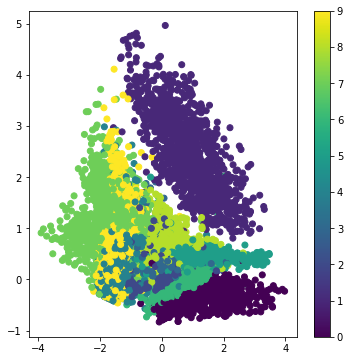

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
x_test_encoded,_,_ = encoder.predict(x_test, batch_size=128)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

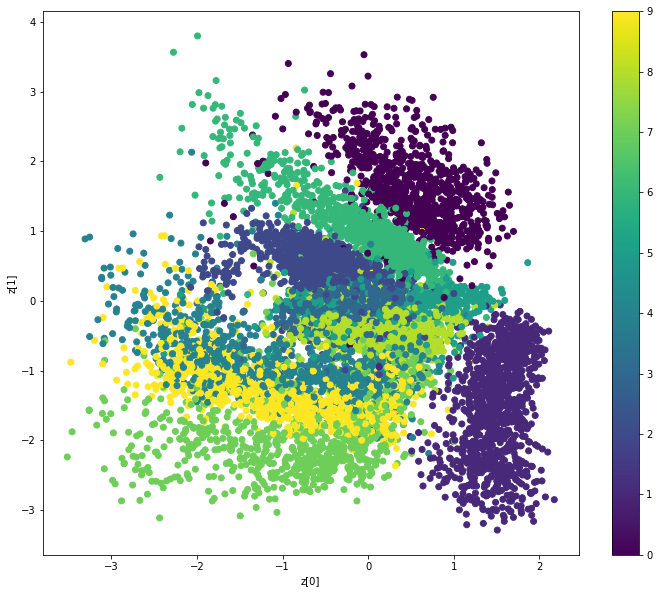

In [13]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_test, y_test)